# !!! THIS NOTEBOOK HAS AN ERROR LEADING TO IMPROPER RANDOM NUMBERS !!!

In [2]:
%matplotlib inline
import pennylane as qml
import numpy as np
import jax
import jax.numpy as jnp
from tqdm import tqdm
import matplotlib as mpl
import matplotlib.pyplot as plt
import types
import qiskit
import utils
mpl.rcParams['figure.facecolor'] = 'white'
mpl.rcParams['axes.labelsize'] = 15

In [17]:
import pennylane.numpy as pnp

### Configuration

In [3]:
num_qubits, num_layers = 4, 1

In [4]:
cf_ideal = utils.Config(
    num_qubits = num_qubits,
    num_layers = num_layers,
    device_name = 'default.qubit',
    simulator_backend = None,
    shots = None,
    diff_method = 'backprop',
    interface = 'jax')

In [36]:
# allows shot noise and also device noise with the cell below
cf_noisy = utils.Config(
    num_qubits = num_qubits,
    num_layers = num_layers,
    device_name = 'qiskit.aer',
    simulator_backend = 'aer_simulator_statevector',
    shots = 1000,
    diff_method = 'parameter-shift',
    interface = 'autograd')

Load a noise model with the cell below to simulate device noise.

In [5]:
# with open('IBMQ_token.txt', 'r') as f:
#     TOKEN = f.read().strip()
# provider = qiskit.IBMQ.enable_account(TOKEN)
# cf_noisy.load_noise_model('ibmq_manila', provider)

### Build a simple circuit

In [37]:
circuit_ideal, device_ideal = cf_ideal.make_device_circuit()
circuit_noisy, device_noisy = cf_noisy.make_device_circuit()

### How to run and draw the circuit

In [21]:
key = jax.random.PRNGKey(42)
shape = qml.StronglyEntanglingLayers.shape(n_layers=num_layers, n_wires=num_qubits)
params = jax.random.uniform(key, shape, minval=0., maxval=2*jnp.pi)
print(f'Output: {circuit_ideal(params)}')
print(qml.draw(circuit_ideal, expansion_strategy="device", max_length=400)(params))

Output: [ 0.20458913  0.59769946 -0.5780215   0.14918712]
0: ──Rot(4.05,0.75,1.91)─╭●───────╭X─┤  <Z>
1: ──Rot(6.12,0.61,1.70)─╰X─╭●────│──┤  <Z>
2: ──Rot(4.47,3.40,1.27)────╰X─╭●─│──┤  <Z>
3: ──Rot(2.23,1.83,1.73)───────╰X─╰●─┤  <Z>


### Define a loss function and optimize it

In [38]:
@jax.jit
def loss_ideal(params):
    return jnp.sum(circuit_ideal(params))
opt_ideal = utils.GradientDescentOptimizer(loss_ideal)
def loss_noisy(params):
    return pnp.sum(circuit_noisy(params))
opt_noisy = utils.GradientDescentOptimizer(loss_noisy)

In [39]:
qml.grad(loss_noisy)(pnp.array(params))

array([[[ 0.009, -0.143,  0.051],
        [ 0.018, -0.275,  0.052],
        [-0.034,  0.09 ,  0.02 ],
        [ 0.024,  1.364,  0.013]]], dtype=float32)

In [40]:
key = jax.random.PRNGKey(0)
initializations = jax.random.uniform(key, (1000, num_layers, num_qubits, 3), minval=0., maxval=2*jnp.pi)

In [41]:
results = [opt_noisy.optimize(ini) for ini in pnp.array(initializations)[:2]]

  0%|                                                                                                                                 | 0/100 [00:00<?, ?it/s]


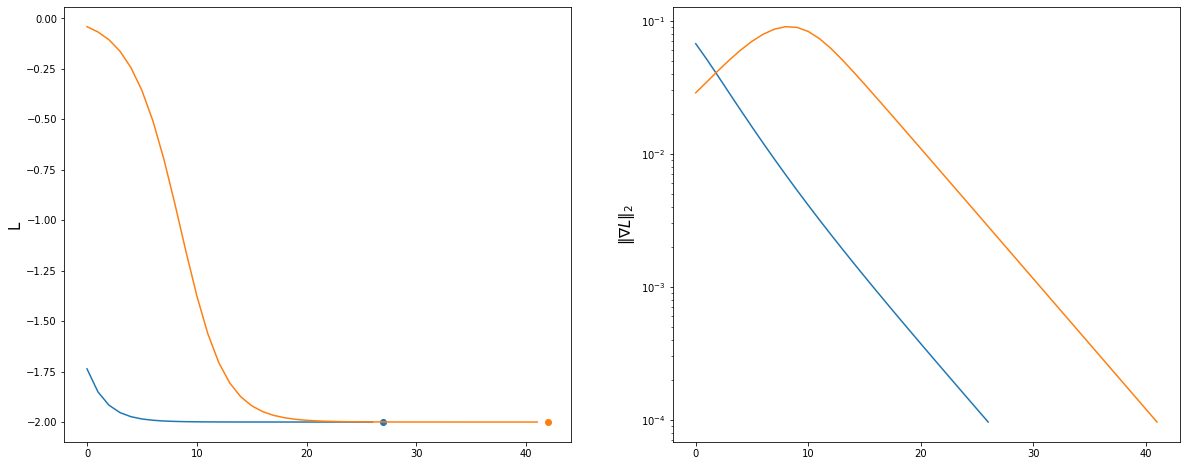

In [17]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
c = plt.get_cmap('tab10').colors
for i, (lh, gh, ph) in enumerate(results):
    i = i % len(c)
    ax1.plot(lh, color=c[i])
    ax1.plot(len(lh), lh[-1], 'o', color=c[i])
    ax1.set_ylabel('L')
    ax2.plot([jnp.linalg.norm(g) / g.size for g in gh])
    ax2.semilogy()
    ax2.set_ylabel(r'$\Vert \nabla L\Vert_2$')

### See how close the final points are to each other

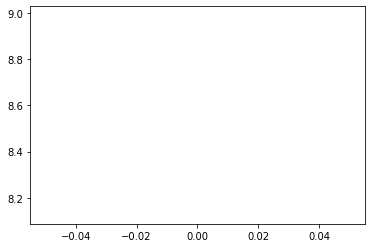

In [18]:
final_points = [r[2][-1] for r in results]
L = len(results)
distances = []
for i in range(L):
    for j in range(i+1, L):
        distances.append(np.linalg.norm(final_points[i] - final_points[j]))
plt.plot(np.sort(distances))

### Pick the ones with a long plateau

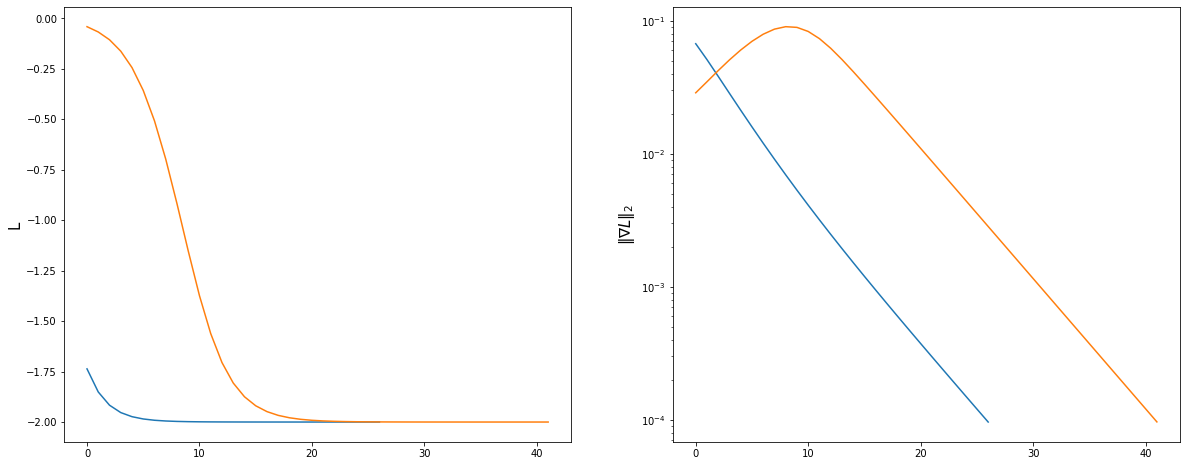

In [21]:
history_lengths = [len(c[0]) for r in results]
selection = np.argsort(history_lengths)[-3:]
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
for i in selection:
    lh, gh, ph = results[i]
    ax1.plot(lh)
    ax1.set_ylabel('L')
    ax2.plot([jnp.linalg.norm(g) / g.size for g in gh])
    ax2.semilogy()
    ax2.set_ylabel(r'$\Vert \nabla L\Vert_2$')

### Compute the Hessian's spectra

In [22]:
hessian_eigs = []
for s in selection:
    lh, gh, ph = results[s]
    h_eigs = []
    for p in tqdm(ph):
        h = jax.hessian(loss_ideal)(p)
        flat_dims = num_layers * num_qubits * 3
        eig, _ = jnp.linalg.eig(h.reshape(flat_dims, flat_dims))
        h_eigs.append(jnp.sort(eig.real))
    hessian_eigs.append(jnp.array(h_eigs))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 82.35it/s]


### A siginificant amout of eigenvalues are 'zero'

[]

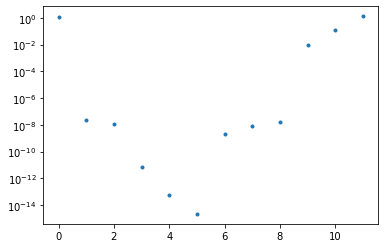

In [23]:
plt.plot(jnp.abs(h_eigs[0]), '.')
plt.semilogy()

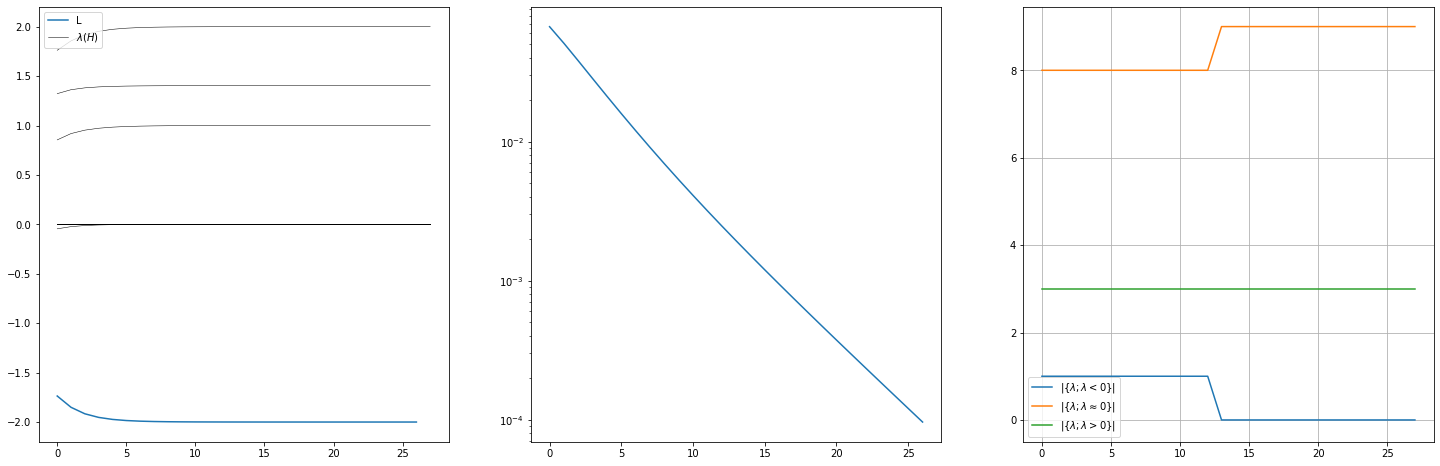

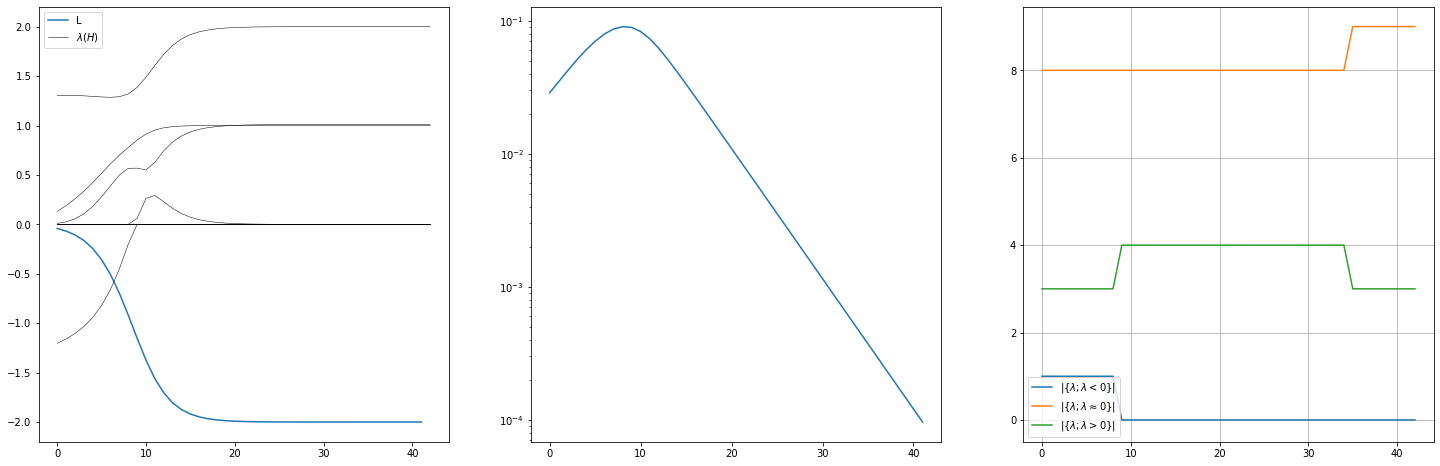

In [24]:
for i, s in enumerate(selection):
    lh, gh, ph = results[s]
    h_eigs = hessian_eigs[i]
    _, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(25, 8))
    ax1.plot(lh)
    ax1.plot(h_eigs, linewidth=.5, color='black')
    ax1.legend(['L', r'$\lambda(H)$'])
    num_signs = []
    for eigs in h_eigs:
        pos = jnp.sum(eigs > 1e-5)
        neg = jnp.sum(eigs < -1e-5)
        zero = len(eigs) - pos - neg
        num_signs.append([neg, zero, pos])
    ax2.plot([jnp.linalg.norm(g) / g.size for g in gh])
    ax3.plot(jnp.array(num_signs))
    ax3.set_ylim(bottom=-.5)
    ax3.grid(True)
    ax3.legend([
        r'$\vert\lbrace\lambda; \lambda<0 \rbrace\vert$',
        r'$\vert\lbrace\lambda; \lambda\approx 0 \rbrace\vert$',
        r'$\vert\lbrace\lambda; \lambda>0 \rbrace\vert$'
    ])
    ax2.semilogy()
    plt.show()